# Membrane Proteome Paper, Figures and Data Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

### Figure 1: Description of what the Asgard membrane proteome is

#### Venn Diagram/ Comparison of TMBed and DeepTMHMM predictions

In [3]:
#Filepaths
#Transmembrane protein prediction files
tm_folder = '/stor/work/Marcotte/project/drbarth/asgard/membrane_proteome/data/raw/tm_predictions/'
all_prots_deep = tm_folder + 'D4994_C39_H1_asgardbins.fasta.deeptmhmm.3line'
all_prots_tmbed = tm_folder + 'D4994_C39_H1_asgardbins.fasta.tmbed.3lines'

In [4]:
#Function to parse through 3lines files for either deeptmhmm or tmbed format: 
def read3line(filepath, format):    
    protein_names = []
    sequence = []
    prediction = []
    with open(filepath, "r") as a_file:
        for line in a_file:
            if line.startswith('>'):
                #split_line = line.strip('\n')
                split_line = line.split('>')
                if format == 'tmbed':
                    split_line = split_line[1].split('\n')
                elif format == 'deeptmhmm':
                    split_line = split_line[1].split(' ')
                prot_name = split_line[0]
                protein_names.append(prot_name)
                for a in range(2):
                    if a == 0:
                        seq = next(a_file)
                        split = seq.split('\n')
                        sequence.append(split[0])
                    else: 
                        pred = next(a_file)
                        pred_split = pred.split('\n')
                        prediction.append(pred_split[0])
    df = pd.DataFrame(list(zip(protein_names, sequence, prediction)),
               columns =['ProteinID', 'aa_sequence', format+'_prediction'])
    return df

In [5]:
deep_df = read3line(all_prots_deep, 'deeptmhmm')
tmbed_df = read3line(all_prots_tmbed, 'tmbed')

In [6]:
tmbed_df.head()

,ProteinID,aa_sequence,tmbed_prediction
0,D4994_C39_H1_Bin_33_scaffold_101747_1,MITRSRGNESRSFNRSTSPNSRSSSSSRSNLDSDSDSDSDSYSNDI...,iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...
1,D4994_C39_H1_Bin_33_scaffold_101747_2,MEEYLIHKGPVSCWDEKTKGEVIALMYHKIIVTVEWYKKNPTNEEF...,iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...
2,D4994_C39_H1_Bin_33_scaffold_101747_3,MKPQFFIGNNVYAMIKAFTKNNKTQGVLTVVPNTVRPDKICSGRFM...,iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...
3,D4994_C39_H1_Bin_33_scaffold_102981_1,MKKNTFTVVTLSVLVLAVMIPMTFPGNDTRVEDQVAMQPDAPVTSY...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSoooooooooo...
4,D4994_C39_H1_Bin_33_scaffold_102981_10,MVEEEREDREEEEGEEGEEEEEGDNLGELVDGGITEDNLANVTGDD...,iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...


In [7]:
#If I want to translate TMBed to DeepTMHMM, TMBed has more info encoded than DeepTMHMM so we'll have to flop this way... Here are the flips: 
# i : I, o : O, S stays as S, B : M, b : M, H : M, and h : M 
tmbed_to_deep_dict = {'i':'I', 'o':'O', 'S':'S', 'B':'M', 'b':'M', 'H':'M', 'h':'M'}

#Make a new dataframe where tmbed_df's tmbed_prediction column is translated to DeepTMHMM's format
tmbed_asdeep_df = tmbed_df.copy()

#A function that will split the column into strings and translate each of the strings
def translate_tmbed_to_deep(tmbed_prediction):
    tmbed_prediction = list(tmbed_prediction)
    tmbed_prediction = [tmbed_to_deep_dict[tmbed_prediction[i]] for i in range(len(tmbed_prediction))]
    tmbed_prediction = ''.join(tmbed_prediction)
    return tmbed_prediction


tmbed_asdeep_df['tmbed_prediction'] = tmbed_asdeep_df['tmbed_prediction'].map(translate_tmbed_to_deep)
tmbed_asdeep_df.head()


,ProteinID,aa_sequence,tmbed_prediction
0,D4994_C39_H1_Bin_33_scaffold_101747_1,MITRSRGNESRSFNRSTSPNSRSSSSSRSNLDSDSDSDSDSYSNDI...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
1,D4994_C39_H1_Bin_33_scaffold_101747_2,MEEYLIHKGPVSCWDEKTKGEVIALMYHKIIVTVEWYKKNPTNEEF...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
2,D4994_C39_H1_Bin_33_scaffold_101747_3,MKPQFFIGNNVYAMIKAFTKNNKTQGVLTVVPNTVRPDKICSGRFM...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
3,D4994_C39_H1_Bin_33_scaffold_102981_1,MKKNTFTVVTLSVLVLAVMIPMTFPGNDTRVEDQVAMQPDAPVTSY...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOO...
4,D4994_C39_H1_Bin_33_scaffold_102981_10,MVEEEREDREEEEGEEGEEEEEGDNLGELVDGGITEDNLANVTGDD...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [8]:
#Now we can compare the predictions properly
#Merge deep_df and tmbed_df
#Drop the aa_seq column from tmbed_df
tmbed_df_tomerge = tmbed_asdeep_df.drop(['aa_sequence'], axis=1)

tm_preds = deep_df.merge(tmbed_df_tomerge, on='ProteinID', how='left')
tm_preds.head()



,ProteinID,aa_sequence,deeptmhmm_prediction,tmbed_prediction
0,D4994_C39_H1_Bin_33_scaffold_101747_1,MITRSRGNESRSFNRSTSPNSRSSSSSRSNLDSDSDSDSDSYSNDI...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
1,D4994_C39_H1_Bin_33_scaffold_101747_2,MEEYLIHKGPVSCWDEKTKGEVIALMYHKIIVTVEWYKKNPTNEEF...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
2,D4994_C39_H1_Bin_33_scaffold_101747_3,MKPQFFIGNNVYAMIKAFTKNNKTQGVLTVVPNTVRPDKICSGRFM...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
3,D4994_C39_H1_Bin_33_scaffold_102981_1,MKKNTFTVVTLSVLVLAVMIPMTFPGNDTRVEDQVAMQPDAPVTSY...,SSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOO...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOO...
4,D4994_C39_H1_Bin_33_scaffold_102981_10,MVEEEREDREEEEGEEGEEEEEGDNLGELVDGGITEDNLANVTGDD...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [9]:
print(f'There are: {tmbed_df_tomerge.shape[0]} proteins in the tmbed dataset and {deep_df.shape[0]} in the deeptmhmm dataset.')

There are: 50979 proteins in the tmbed dataset and 50979 in the deeptmhmm dataset.


In [10]:
#How can I compare the two outputs here?
# I could do an alignment of the two outputs and see how much overlap there is? But that might be a bit deeper than necessary right now. 
# How about first, let's go through and determine the number of transmembrane residues in each protein. -- essentially if an M is present
# Then I think it would be cool to see if there are any Signal Peptides predicted as well 
def num_tm_residues(seq):
    """
    This function takes a sequence and returns the number of transmembrane residues in the sequence
    """
    tm_residues = 0
    l = len(seq)
    for i in range(1,l):
        prev = seq[i-1]
        residue = seq[i]
        if residue == 'M':
            if prev != 'M':
                tm_residues += 1
            elif tm_residues == 0:
                tm_residues += 1
    return tm_residues

In [11]:
def num_signal_peptides(seq):
    """Return the number of signal peptides in a sequence."""
    signal_peptides = 0
    l = len(seq)
    for i in range(1,l):
        prev = seq[i-1]
        residue = seq[i]
        if residue == 'S':
            if prev != 'S':
                signal_peptides += 1
            elif signal_peptides == 0:
                signal_peptides += 1
    return signal_peptides

In [12]:
#Apply the num_tm_residues function to the dataframe
#df['num_tm_residues'] = df['sequence'].apply(num_tm_residues)
tm_preds['num_tm_residues_deep'] = tm_preds['deeptmhmm_prediction'].apply(num_tm_residues)
tm_preds['num_signal_deep'] = tm_preds['deeptmhmm_prediction'].apply(num_signal_peptides)

tm_preds['num_tm_residues_tmbed'] = tm_preds['tmbed_prediction'].apply(num_tm_residues)
tm_preds['num_signal_tmbed'] = tm_preds['tmbed_prediction'].apply(num_signal_peptides)

tm_preds.head()

,ProteinID,aa_sequence,deeptmhmm_prediction,tmbed_prediction,num_tm_residues_deep,num_signal_deep,num_tm_residues_tmbed,num_signal_tmbed
0,D4994_C39_H1_Bin_33_scaffold_101747_1,MITRSRGNESRSFNRSTSPNSRSSSSSRSNLDSDSDSDSDSYSNDI...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,1,0,1,0
1,D4994_C39_H1_Bin_33_scaffold_101747_2,MEEYLIHKGPVSCWDEKTKGEVIALMYHKIIVTVEWYKKNPTNEEF...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,0,0,0,0
2,D4994_C39_H1_Bin_33_scaffold_101747_3,MKPQFFIGNNVYAMIKAFTKNNKTQGVLTVVPNTVRPDKICSGRFM...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,0,0,0,0
3,D4994_C39_H1_Bin_33_scaffold_102981_1,MKKNTFTVVTLSVLVLAVMIPMTFPGNDTRVEDQVAMQPDAPVTSY...,SSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOO...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOO...,1,1,1,1
4,D4994_C39_H1_Bin_33_scaffold_102981_10,MVEEEREDREEEEGEEGEEEEEGDNLGELVDGGITEDNLANVTGDD...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,0,0,0,0


In [13]:
tm_preds['deeptmhmm_prediction'][4]

'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'

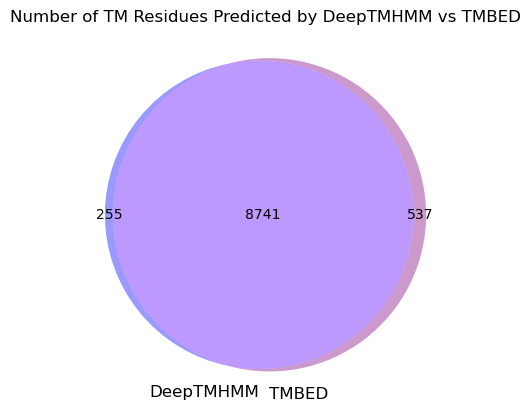

In [14]:
#Plot a Venn Diagram Comparing the num_tm_resides predicted by deeptmhmm vs tmbed
from matplotlib_venn import venn2

#Get number of proteins predicted to have TM regions by DeepTMHMM
deep_predicted_tms = tm_preds[tm_preds['num_tm_residues_deep'] != 0]
tmbed_predicted_tms = tm_preds[tm_preds['num_tm_residues_tmbed'] != 0]

#Create a venn diagram comparing the two
venn2([set(deep_predicted_tms['ProteinID']), set(tmbed_predicted_tms['ProteinID'])], set_labels = ('DeepTMHMM', 'TMBED'), set_colors=('blue', 'purple'))
plt.title('Number of TM Residues Predicted by DeepTMHMM vs TMBED')
plt.show()


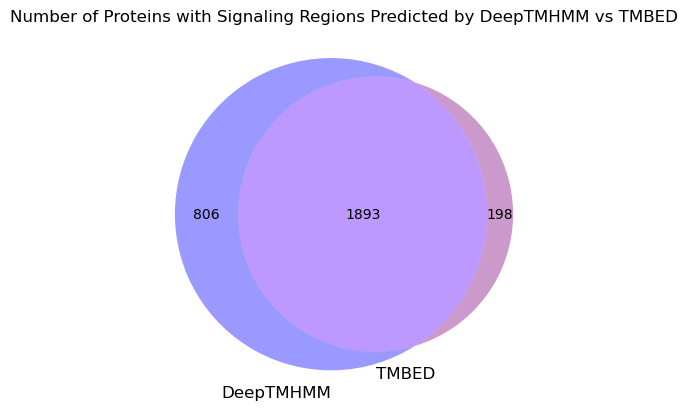

In [15]:
#Create a venn diagram comparing the signal peptides predicted by DeepTMHMM and TMBED
deep_predicted_signals = tm_preds[tm_preds['num_signal_deep'] != 0]
tmbed_predicted_signals = tm_preds[tm_preds['num_signal_tmbed'] != 0]

venn2([set(deep_predicted_signals['ProteinID']), set(tmbed_predicted_signals['ProteinID'])], set_labels = ('DeepTMHMM', 'TMBED'), set_colors=('blue', 'purple'))
plt.title('Number of Proteins with Signaling Regions Predicted by DeepTMHMM vs TMBED')
plt.show()

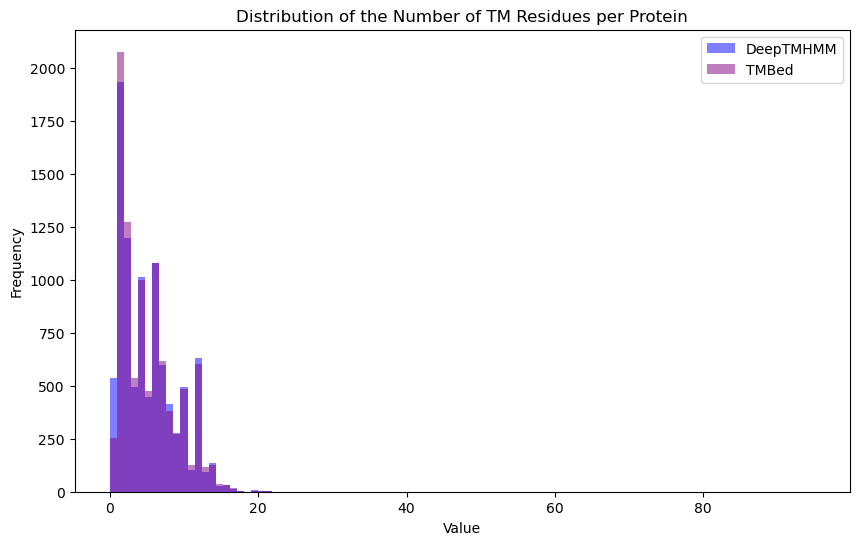

In [16]:
# Plot histogram of the distribution of the number of TMR residues per protein predicted by deeptmhmm and tmbed
#Plot a histogram with two columns
# 1. Number of TMR residues predicted by deeptmhmm
# 2. Number of TMR residues predicted by tmbed

# Plot histograms
plt.figure(figsize=(10, 6))  # Optional: adjust the figure size

#Filter tm_preds to only include proteins that have a non-zero value in num_tm_residues_deep and num_tm_residues_tmbed
tm_preds_TMRs = tm_preds[(tm_preds['num_tm_residues_deep'] > 0) | (tm_preds['num_tm_residues_tmbed'] > 0)]

# Plot histogram for column1
plt.hist(tm_preds_TMRs['num_tm_residues_deep'], bins=100, alpha=0.5, label='DeepTMHMM', color='blue')

# Plot histogram for column2
plt.hist(tm_preds_TMRs['num_tm_residues_tmbed'], bins=100, alpha=0.5, label='TMBed', color='purple')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of the Number of TM Residues per Protein')
plt.legend()

plt.show()



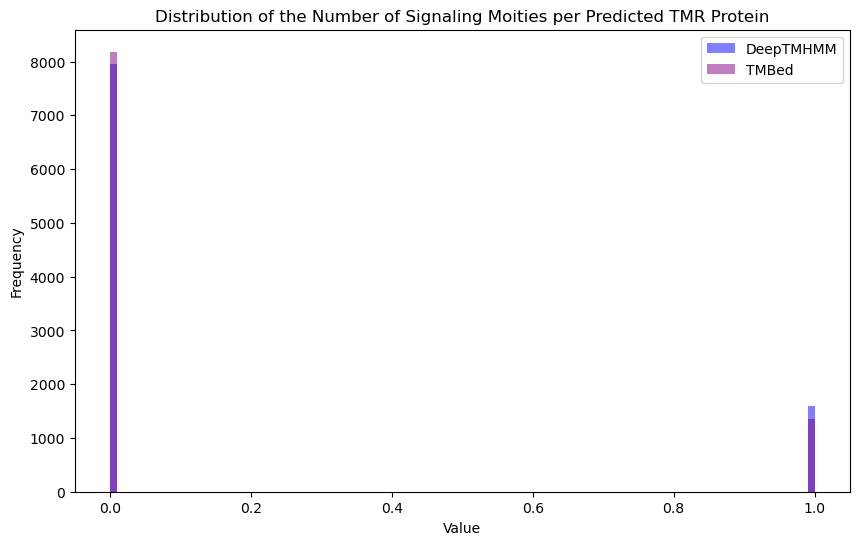

In [17]:
# Only 1 signaling region is ever predicted per protein 
# Let's look at the proportion of the proteins with TMRs that also have signals -- this is better as a bar plot
# Plot histogram of the distribution of the number of signal residues per protein predicted by deeptmhmm and tmbed
# Plot histograms
plt.figure(figsize=(10, 6))  # Optional: adjust the figure size

# Plot histogram for column1
plt.hist(tm_preds_TMRs['num_signal_deep'], bins=100, alpha=0.5, label='DeepTMHMM', color='blue')

# Plot histogram for column2
plt.hist(tm_preds_TMRs['num_signal_tmbed'], bins=100, alpha=0.5, label='TMBed', color='purple')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of the Number of Signaling Moities per Predicted TMR Protein')
plt.legend()

plt.show()












##### Graph Distribution of TMRs among the Asgard phylas and connect the x-axis labels via phylogeny

In [22]:
# conda install -c etetoolkit ete3 <-- will need this toolkit to make this graph 
# wasn't working (ModuleNotFoundError) so ran ete3 build check on the command line
# Recommended to install the ete_toolchain: conda install -c etetoolkit ete_toolchain




In [21]:
from ete3 import Tree



ModuleNotFoundError: No module named 'ete3'

In [ ]:
# Create a sample DataFrame with species and their corresponding values
data = {'Species': ['Species A', 'Species B', 'Species C', 'Species D'],
        'Value': [20, 30, 15, 25]}

df = pd.DataFrame(data)

# Create a Newick string representing the phylogenetic tree
newick_tree = "(Species A,(Species B,(Species C,Species D)));"

# Load the phylogenetic tree
tree = Tree(newick_tree)

# Plot the phylogenetic tree
plt.figure(figsize=(10, 6))  # Adjust the figure size

# Plot the tree
ts = tree.render('%%inline', tree_style=tree_style)

# Add a bar plot as an overlay
ax = plt.gca()  # Get the current axes
ax2 = ax.twinx()  # Create a twin axes for the bar plot

# Plot the bar plot on the twin axes
df.plot(kind='bar', x='Species', y='Value', ax=ax2, color='blue', alpha=0.7)

# Adjust the positions and labels of the x-axis ticks for the bar plot
ax2.set_xticks([i for i, _ in enumerate(df['Species'])])
ax2.set_xticklabels(df['Species'])

plt.title('Phylogenetic Tree with Bar Plot Overlay')
plt.show()